<h1 dir=rtl align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#0099cc">
خوشه‌بندی رفتار مشتریان</font>
</h1>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
فرض کنید شما تحلیل‌گر داده یک فروشگاه آنلاین هستید. دیتاستی در اختیار دارید که اطلاعات مربوط به سفارشات مشتریان را در آن ثبت کرده‌اید. با استفاده از روش‌های خوشه‌بندی، مشتریان را بر اساس رفتار خریدشان خوشه‌بندی کنید.
</font>
</p>

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#0099cc">
معرفی مجموعه داده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
    در پوشه این تمربن یک فایل با نام <code>orders.csv</code> قرار دارد.
    مجموعه‌داده‌ی این سوال شامل ۲۰۰٬۰۰۰ سطر و ۷ ستون است و
    توضیحات مربوط به ستون‌ها به شرح زیر است:
</font>
</p>

<center>
<div dir=rtl style="direction: rtl;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>

| ستون | توضیح |
|:------:|:-------:|
| `ID_Order` | شناسه یکتای هر سفارش است. هر ردیف جدول نماینده یک سفارش خاص است. |
| `ID_Customer` | شناسه یکتای مشتری است که سفارش را ثبت کرده است. ممکن است یک مشتری چند سفارش داشته باشد. |
| `ID_Item` | شناسه یکتای آیتم یا محصول سفارش‌داده‌شده. در واقع مشخص می‌کند چه محصولی در سفارش آمده است. |
| `DateTime_CartFinalize` | زمان نهایی‌سازی سبد خرید است، یعنی لحظه‌ای که سفارش نهایی شده. این ستون برای استخراج اطلاعات زمانی (مثلاً فصل خرید، ساعت روز، روز هفته) می‌تواند کاربردی باشد. |
| `Amount_Gross_Order` | مبلغ ناخالص سفارش به تومان یا هر واحد پولی دیگر. شامل کل هزینه سفارش (شاید بدون تخفیف یا مالیات). |
| `city_name_fa` | نام فارسی شهری که سفارش از آن ثبت شده. |
| `Quantity_item` | تعداد آیتم سفارش‌داده‌شده از آن محصول در سفارش. |

</font>




<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#0099cc">
خواندن مجموعه داده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
    در ابتدا نیاز است فایل مجموعه‌داده را بخوانید.  مجموعه داده تمرین، در فایل <code>orders.csv</code> ذخیره شده‌است.
</font>
</p>

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv("orders.csv")

<h2 align=right style="line-height:200%;font-family:vazir;color:#ff1111">
<font face="vazirmatn" color="#ff1111">
پیش‌پردازش و مهندسی ویژگی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
     شما می‌توانید از هر تکنیک پیش‌پردازش/مهندسی ویژگی که صلاح می‌دانید، استفاده کنید.
</font>
</p>









In [23]:
df['DateTime_CartFinalize'] = pd.to_datetime(df['DateTime_CartFinalize'])

In [24]:
customer_features = df.groupby('ID_Customer').agg(
    purchase_count=('ID_Order', 'count'),
    total_spent=('Amount_Gross_Order', 'sum'),
    avg_spent=('Amount_Gross_Order', 'mean'),
    max_spent=('Amount_Gross_Order', 'max'),
    total_quantity=('Quantity_item', 'sum'),
    unique_items=('ID_Item', 'nunique'),
    first_purchase=('DateTime_CartFinalize', 'min'),
    last_purchase=('DateTime_CartFinalize', 'max')
).reset_index()

In [25]:
reference_date = df['DateTime_CartFinalize'].max() + pd.Timedelta(days=1)
customer_features['recency'] = (reference_date - customer_features['last_purchase']).dt.days
customer_features['customer_lifetime'] = (customer_features['last_purchase'] - customer_features['first_purchase']).dt.days
customer_features['avg_order_value'] = customer_features['total_spent'] / customer_features['purchase_count']

customer_features['RFM_Total'] = customer_features['recency'] * -1 + customer_features['purchase_count'] + customer_features['total_spent']

features = [
    'purchase_count',
    'total_spent',
    'avg_spent',
    'max_spent',
    'total_quantity',
    'unique_items',
    'recency',
    'customer_lifetime',
    'avg_order_value',
    'RFM_Total'
]

X = customer_features[features]

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<h2 dir=rtl align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#0099cc">
انتخاب تعداد خوشه‌ها و آموزش مدل
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>
    حال که داده را پاکسازی کرده و احتمالا ویژگی‌هایی را به آن افزوده یا از آن حذف کرده‌اید، وقت آن است که ابتدا براساس روش‌هایی که می‌دانید تعداد خوشه‌های مناسب برای این سوال را پیدا کنید و سپس بر اساس آن مدلی آموزش دهید
     
</font>
</p>

In [27]:
scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score

    print(f"{k = }, {score = }")

scores

k = 2, score = 0.7531074102545533
k = 3, score = 0.7493785656995856
k = 4, score = 0.6174934879869666
k = 5, score = 0.39447762641034556
k = 6, score = 0.4050244398964418


{2: 0.7531074102545533,
 3: 0.7493785656995856,
 4: 0.6174934879869666,
 5: 0.39447762641034556,
 6: 0.4050244398964418}

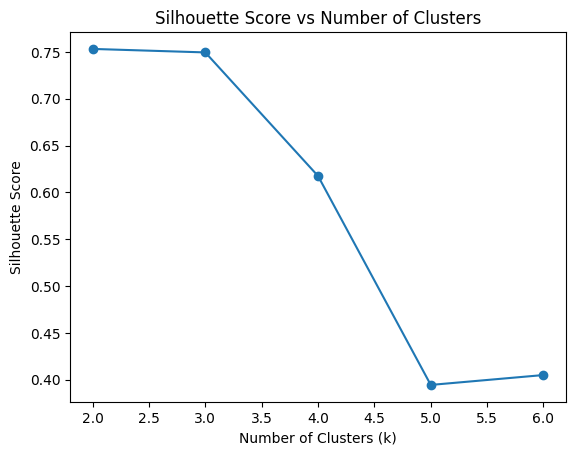

In [28]:
k_values = list(scores.keys())
sil_scores = list(scores.values())

plt.figure()
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

In [29]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#ff1111">
 پیش‌بینی برای داده تست و خروجی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
    پس از مهندسی ویژگی و مدل‌سازی، الگوریتمی دارید که می‌تواند شما را از متغیرهای هر نمونه، به خوشه آن برساند.
    <br>
    از این مدل برای پیش‌بینی خوشه نمونه‌های موجود در داده <b><i>orders.csv</i></b> استفاده کنید و نتایج را در قالب جدول زیر آماده کنید.
</font>
</p>

<center>
<div dir=rtl style="direction: rtl;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>
    
|ستون|توضیحات|
|:------:|:---:|
|Cluster|خوشه منتصب به هر نمونه|
    
</font>
</div>
</center>



<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>
    <br>
    این دیتافریم تنها شامل ۱ ستون با اسم <i>Cluster</i> است و ۲۰۰٬۰۰۰ سطر دارد.
    <br>
    به ازای هر سطر موجود در فایل <i>orders.csv</i> شما باید یک مقدار پیشبینی شده داشته باشید.
</font>
</p>



<p dir=rtl style="direction: rtl; text-align: center; line-height:200%; font-family:vazir; font-size:medium; color:#ff1111">
<font face="vazirmatn" size=4 color:"#ff1111">
    در این تمرین، مجموعه داده‌هایی جداگانه برای آزمون یا آموزش نداریم و شما باید خروجی مدل خود را برای همان مجموعه داده‌ای که در اول تمرین، از فایل بارگذاری کردید، در دیتافریم  ذخیره کنید.
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>
    جدول زیر، ۵ سطر ابتدایی دیتافریم  را نشان می‌دهد. البته در جواب شما، اعداد ستون <i>Cluster</i> ممکن است متفاوت باشد.
</font>
</p>


<div style="text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size=3>
    
||Cluster|
|:----:|:-----:|
|0|1|
|1|1|
|2|0|
|3|1|
|4|0|

</font>
</div>



In [30]:
customer_features['Cluster'] = labels

In [31]:
orders_with_cluster = df.merge(
    customer_features[['ID_Customer', 'Cluster']],
    on='ID_Customer',
    how='left'
)

In [32]:
final_output = orders_with_cluster[['Cluster']]

In [33]:
final_output.to_csv("cluster_predictions.csv", index=False)

<h3 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazirmatn" color="#0099cc">
معیار ارزیابی
</font>
</h3>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazirmatn" size=3>
    معیار <code>silhouette score</code> را برای ارزیابی کیفیت مدل خود محاسبه کنبد .
    <br>
    
</font>
</p>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font color="red"><b color='red'>توجه:</b></font>
<font face="vazirmatn" size=3>
 جهت کسب امتیاز کامل نیاز است تا پاسخ شما حداقل امتیاز <code>85</code> را با توجه به معیار معرفی‌شده کسب نماید.
</font>
</p>

In [34]:
sil_score = silhouette_score(X_scaled, labels)

In [35]:
print( 100 * (sil_score + 1 ) / 2 )

87.65537051272767
